Using TensorFlow backend.


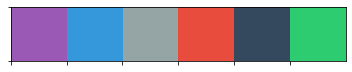

In [1]:
# Toolbox
from pathlib import Path
from imutils import paths
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Misc
import random
import gc
import glob
import shutil
import joblib
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

# Deep learning
import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, UpSampling2D
from keras.layers import GlobalMaxPooling2D, Input, GlobalAveragePooling2D, LeakyReLU, Conv2DTranspose, Add, multiply, Permute, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras import utils

# Evaluation
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

# Preset data display
pd.options.display.max_seq_items = 1000
pd.options.display.max_rows =1000
pd.set_option('display.max_columns', 50)

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite code to use: #34995e

In [2]:
import tensorflow as tf
import tensorflow.keras
import keras

print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Keras Version: {tensorflow.keras.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print("TensorFlow-GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print(f"TensorFlow CUDA: {tf.test.is_built_with_cuda()}")
print(f"Tensorflow GPU Device Currently Activated: {tf.test.gpu_device_name()}")
print(f"Keras GPU: {keras.backend.tensorflow_backend._get_available_gpus()}")
print()
print(f"TF Session: {tf.Session()}")
print()
print(f"Python {sys.version}")

TensorFlow Version: 1.13.1
TensorFlow Keras Version: 2.2.4-tf
Keras Version: 2.2.4

TensorFlow-GPU is available
TensorFlow CUDA: True
Tensorflow GPU Device Currently Activated: /device:GPU:0
Keras GPU: ['/job:localhost/replica:0/task:0/device:GPU:0']

TF Session: <tensorflow.python.client.session.Session object at 0x0000024AF2C60588>

Python 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


### Helpers

In [3]:
def plot_history(model):
    acc = model.history['acc']
    val_acc = model.history['val_acc']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()
    
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get Values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

### Data

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
# train = train[:10000]
# test = test[:10000]

In [6]:
print(train.shape)
print(test.shape)

(300000, 25)
(200000, 24)


In [7]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [8]:
get_nulls(train)

There are 0 columns with missing values.


,Null Data Count,Null Data Pct


In [9]:
train.describe()

,id,bin_0,bin_1,bin_2,ord_0,day,month,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.00000
mean,149999.500000,0.127503,0.256607,0.383223,1.479567,3.007817,5.771113,0.30588
std,86602.684716,0.333537,0.436761,0.486173,0.712524,1.817949,3.843519,0.46078
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000
25%,74999.750000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,0.00000
50%,149999.500000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,0.00000
75%,224999.250000,0.000000,1.000000,1.000000,2.000000,4.000000,9.000000,1.00000
max,299999.000000,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000,1.00000


In [10]:
train.dtypes

id         int64
bin_0      int64
bin_1      int64
bin_2      int64
bin_3     object
bin_4     object
nom_0     object
nom_1     object
nom_2     object
nom_3     object
nom_4     object
nom_5     object
nom_6     object
nom_7     object
nom_8     object
nom_9     object
ord_0      int64
ord_1     object
ord_2     object
ord_3     object
ord_4     object
ord_5     object
day        int64
month      int64
target     int64
dtype: object

### Combine

In [11]:
test['target'] = -1
data = pd.concat([train, test]).reset_index(drop=True)

In [12]:
features = [x for x in train.columns if x not in ['id', 'target']]

### Label encode all features

In [13]:
for feature in features:
    lbl_enc = LabelEncoder()
    data[feature] = lbl_enc.fit_transform(data[feature].values)

In [14]:
train = data[data.target != -1].reset_index(drop=True)
test = data[data.target == -1].reset_index(drop=True)

### Split

In [15]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,1,1,1,5,5,3,0,78,120,491,1689,2192,1,2,1,7,3,136,1,1,0
1,1,0,1,0,1,1,1,4,3,5,2,159,510,260,652,11719,0,2,3,0,0,93,6,7,0
2,2,0,0,0,0,1,0,4,4,5,3,44,14,766,1935,8140,0,1,4,7,17,31,6,1,0
3,3,0,1,0,0,1,2,4,5,0,1,209,165,1121,631,6098,0,2,0,8,3,134,1,0,1
4,4,0,0,0,0,0,2,4,4,0,1,90,61,34,1763,8293,0,2,2,0,17,158,6,7,0


In [16]:
test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,300000,0,0,1,1,1,0,5,0,3,2,8,320,372,1370,2836,1,4,5,9,15,95,4,10,-1
1,300001,0,0,0,1,0,2,2,4,0,2,151,53,79,597,1906,0,3,4,11,0,61,6,4,-1
2,300002,1,0,1,0,1,0,2,2,1,2,84,61,164,1574,5214,1,1,2,0,6,172,0,11,-1
3,300003,0,0,1,1,1,2,3,1,1,2,173,334,199,107,8521,0,0,4,1,16,135,1,2,-1
4,300004,0,1,1,0,0,2,4,2,1,2,197,305,752,2160,7027,2,2,4,11,22,157,3,10,-1


In [17]:
y = train[['target']]
X = train.drop(['id', 'target'], axis=1)

In [18]:
X_array = X.values

In [19]:
X_array.shape

(300000, 23)

In [20]:
X.shape

(300000, 23)

In [21]:
type(X)

pandas.core.frame.DataFrame

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_array, y, test_size=0.3, random_state=100)

In [23]:
scaler = StandardScaler()

# Transform the features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
print(X_train.shape)

(210000, 23)


In [25]:
X_train

array([[-0.38118296, -0.58762974, -0.78857279, ..., -1.39007646,
        -0.55473124,  1.62002433],
       [-0.38118296, -0.58762974,  1.26811375, ...,  1.51308929,
        -1.10509885, -1.24354986],
       [ 2.62341211, -0.58762974, -0.78857279, ...,  1.51308929,
        -0.00436363, -0.98322494],
       ...,
       [-0.38118296, -0.58762974, -0.78857279, ...,  1.13441549,
         0.54600398, -0.98322494],
       [-0.38118296,  1.70175184, -0.78857279, ...,  0.59345293,
         0.54600398,  0.57872463],
       [-0.38118296, -0.58762974,  1.26811375, ..., -0.77698556,
        -1.10509885,  1.09937448]])

### Model

In [26]:
# Define model parameters
batch_size = 256
epochs = 50

# Build the neural network
def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1], )),
        Dropout(0.3),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(1, activation='sigmoid') # no activation if regression; usually an output of 1; Dense(1, activation='sigmoid')   
    ])
    
    # Compile
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [27]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
# Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               6144      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total para

In [29]:
# Define callback if there's no improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

### Fitting the model (initial attempt)

In [30]:
%%time 
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stop],
                    validation_data = (X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 210000 samples, validate on 90000 samples
Epoch 1/50
210000/210000 [==============================] - 5s 22us/step - loss: 0.5782 - acc: 0.7019 - val_loss: 0.5347 - val_acc: 0.7302
Epoch 2/50
210000/210000 [==============================] - 4s 17us/step - loss: 0.5434 - acc: 0.7238 - val_loss: 0.5296 - val_acc: 0.7344
Epoch 3/50
210000/210000 [==============================] - 4s 18us/step - loss: 0.5388 - acc: 0.7281 - val_loss: 0.5278 - val_acc: 0.7353
Epoch 4/50
210000/210000 [==============================] - 4s 18us/step - loss: 0.5363 - acc: 0.7297 - val_loss: 0.5265 - val_acc: 0.7361
Epoch 5/50
210000/210000 [==============================] - 4s 17us/step - loss: 0.5348 - acc: 0.7299 - val_loss: 0.5263 - val_acc: 0.7359
Epoch 6/50
210000/210000 [==============================] - 4s 17us/step - loss: 0.5329 - acc: 0.7316 - val_loss: 0.5251 - val_acc: 0.7370
Epoch 7/50
210000/210000 [==============================] - 4s 17us

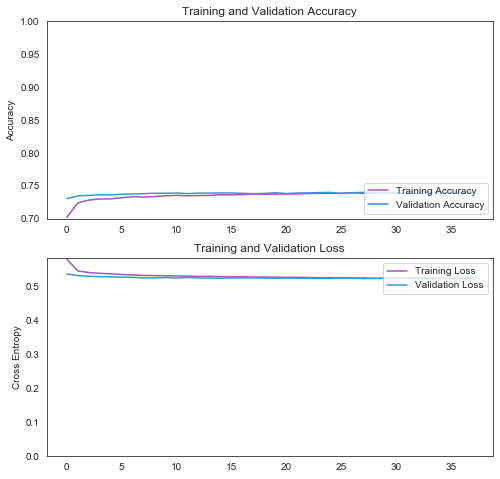

In [31]:
plot_history(history)

### Evaluation

In [46]:
# Once trained, find out how the model has performed
test_pred = model.predict(X_test)
test_pred = [1 if test_pred >= 0.50 else 0]

# Compare predicted value to the actual y_test variable
print('CM:')
cm = confusion_matrix(y_test.values, test_pred)
print(cm)
print('Classification Report:')
print(classification_report(y_test, test_pred))

print('Evaluation Metrics:')
print('Accuracy Score: {}'.format(round(accuracy_score(y_test, test_pred), 4)))
print("Precision:", precision_score(y_test, test_pred))
print("Recall:", recall_score(y_test, test_pred))
print("F1 Score:", f1_score(y_test, test_pred))

sns.heatmap(cm, 
            annot=True,
            fmt='d')
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [43]:
type(y_test.values)

numpy.ndarray

In [42]:
type(test_pred)

numpy.ndarray

### Prediction

In [ ]:
# Predictions - convert dataframe to np.ndarray
test_data = test.values
test_predictions = model.predict(test_data).flatten() # Return a copy of the array collapsed into one dimension

In [ ]:
model.predict(test_data).flatten()

In [32]:
# test_preds /= 50
# test_ids = test.id.values
# print('Saving submission file')
# submission = pd.DataFrame.from_dict({
#     'id': test_ids,
#     'target': test_preds
# })

In [33]:
# submission.to_csv('submission.csv', index=False)